# Practical Session 5 - Parallel Markov chains with multiprocessing and dask

Students (pair):
- [BLANQUART Ekhi](https://github.com/azagal952)
- [DENISSELLE Alexis](https://github.com/AlexisDns23)


**Useful references for this lab**:

[1] `seaborn`: [official tutorial](https://seaborn.pydata.org/tutorial.html)

[2] `multiprocessing`: [documentation](https://docs.python.org/3/library/multiprocessing.html), [doc2](https://he-arc.github.io/livre-python/multiprocessing/index.html)

[3] `dask`: [documentation](http://numba.pydata.org/) 

## <a name="content">Contents</a>
- [Exercise 1: seaborn, a useful tool for data visualisation](#ex1)
- [Exercise 2: Simulating a discrete-time homogeneous Markov chain](#ex2)
- [Bonus: Parallel computing with Dask](#bonus)
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import multiprocessing as mp
import dask.distributed as dask
import dask.array as da
from numba import jit

## <a name="ex1">Exercise 1: seaborn, a useful tool for data visualisation</a> [(&#8593;)](#content)
 
The `seaborn` package can significantly enhance data and data analysis visualization. See the [tutorial page](https://seaborn.pydata.org/tutorial.html) for examples of effective predefined graphics. An example aimed at visualizing the empirical distributions of 9 realizations of a bivariate Gaussian random vector is reported below.

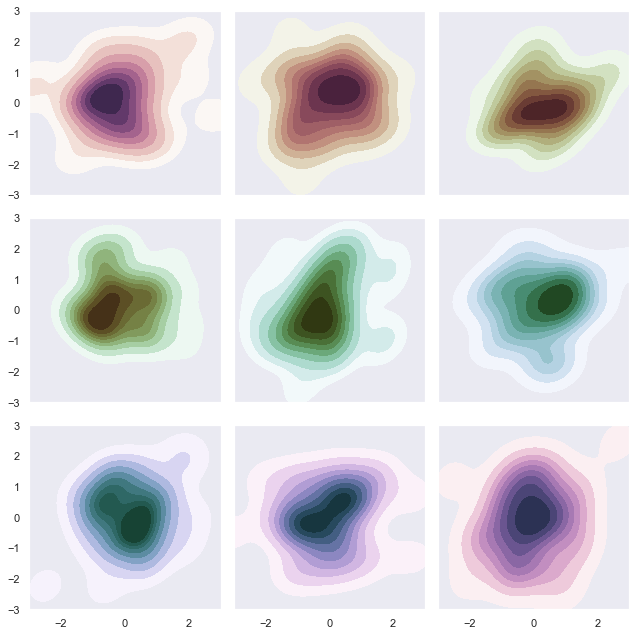

In [3]:
sns.set_theme(style="dark")
rng = np.random.default_rng(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rng.normal(size=(2, 50))
    sns.kdeplot(x=x, y=y, cmap=cmap, fill=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

1. Comment on the lines of codes related to the `seaborn` library to make their role explicit. More specifically comment on the KDE method.

**Answer:**

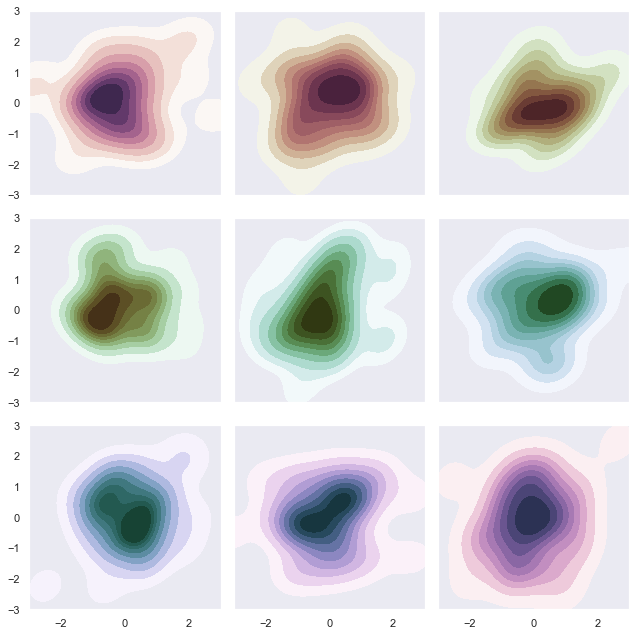

In [4]:
# Choose a theme
sns.set_theme(style="dark")
rng = np.random.default_rng(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    # cubehelix is a color mapping that looks good, even in grayscale
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rng.normal(size=(2, 50))
    #Kernel density estimation
    sns.kdeplot(x=x, y=y, cmap=cmap, fill=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

The Kernel Density Estimation method is used to estimate the density function lying under a set of observations. Especially, this method is non-parametric and produces a continuous estimator. Actually, the estimator is a sum of kernels (a positive symmetric function that integrates to 1), centered for each observation and averaged by the total number of observations.

2. For one of the realizations, take a look at the documentation of [`sns.jointplot`](https://seaborn.pydata.org/examples/joint_kde.html) to display both the 2-D empirical distribution of the data, and 1D histograms of their distribution along each axis. 

**Answer:**

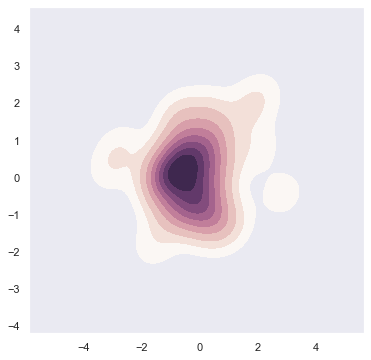

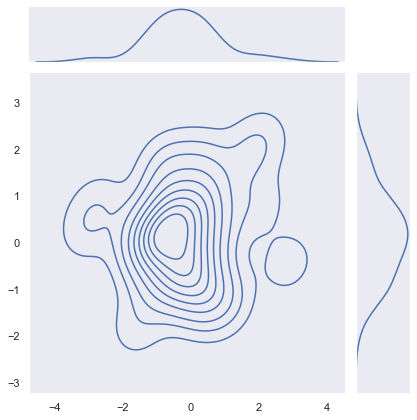

In [5]:
rng = np.random.default_rng(50)

# Create a cubehelix colormap to use with kdeplot
cmap = sns.cubehelix_palette(start=0, light=1, as_cmap=True)

# Generate and plot a random bivariate dataset
x, y = rng.normal(size=(2, 50))
plt.figure(figsize=(6,6))
sns.kdeplot(x=x, y=y, cmap=cmap, fill=True, cut=5)
plt.show()

# Show the joint distribution using kernel density estimation
g = sns.jointplot(x=x, y=y, kind="kde")

The two components distributions look like normal distributions, as expected. 

## <a name="ex2">Exercise 2: Simulating a discrete-time homogeneous Markov chain.</a> [(&#8593;)](#content)


Let ${(X_n)}_{n\geq 0}$ be a discrete-time homogeneous Markov chain with values over a finite ensemble $E=\{x_1,\dots,x_N\}$ identified to $\{1,\dots,N\}$. Consider $\boldsymbol{\rho} \in \Delta_N$, where $\Delta_N = \{\mathbf{x}\in\mathbb{R}^N \mid x_n \geq 0 \, \forall n \in \{1,\dotsc,N\} \text{ and } \sum_n x_n = 1 \}$ is the unit simplex in $\mathbb{R}^N$.

In the following, we consider the initial state of the chain $X_0$, following the discrete probability distribution:

$$
    \mathbb{P}(X_0 = k) = \rho_k, \qquad k \in \{1, \dots,  N\}.
$$
  
Let $\mathbf{A} = [a_{i,j}]_{i,j} \in \mathbb{R}^{N \times N}$ be the transition matrix of the chain, i.e.,

\begin{align*}
    &a_{i,j} = \mathbb{P}(X_{n+1} = j \mid X_{n} = i) \geq 0, \, \forall n \geq 0, \\
    &(\forall i \in \{1, \dotsc, N\}), \quad \sum_{j=1}^N a_{i,j} = 1.
\end{align*}
 
The chain is said to be homogeneous in that $\mathbf{A}$ does not depend from the time index $n$. Let $\tilde{a}_n$ represent the $n$-th row of $\mathbf{A}$. 

The trajectory of the chain can be simulated as follows:

>- Draw the discrete random variable $X_0$ with distribution $\boldsymbol{\rho}$;
>
>- For $q = 0$ to $n_{\text{iter}}-1$
>    - Draw the discrete random variable $X_{q+1}$ with distribution $\tilde{a}_{X_{q}}$;
>    
>- Return ${(X_q)}_{0 \leq q \leq n_{\text{iter}}}$.


<!-- If $X_n = k$, we know that $T$, the life time of the chain in the state $k$ obeys a geometric distribution with parameter $a_{kk}$. We also know that the probability of transition from k to $\ell\neq k$ is given by:

$$
    \mathbb{P}(X_{n+1}=\ell | X_n=k, \ell\neq k) = \frac{a_{k\ell}}{1-a_{kk}}.
$$

 ### One possible algorithm to simulate a Markov chain is therefore:

    a. generate the initial state $X_0$ according to the discrete law $\{\rho_1,\dots,\rho_N\}$.

    b. at instant $n$, knowing that $X_n=k$,

    i) determine the life time $T$ in state $X_n=k$ by simulating a geometrical variable with parameter $a_{kk}$. As a consequence $X_n = \dots = X_{n+T} = k$. When $T=0$, we simply still have $X_n=k$.

    ii) determine next transition instant $n+T$, and determine the next state by using the probabilities of transition. -->

1. Implement the above algorithm in a function `X = markov(rho,A,nmax,rng)` with:
     - `rho`: law of the initial state (nonnegative vector of size $N$, summing to 1),
     - `A`: transition matrix (of size $N\times N$),
     - `nmax`: number of time steps,
     - `rng`: random number generator
     - `X`: trajectory of the chain.
     
In particular, check the input parameters `A` and `rho` make sense by adding appropriate assertions (or raising exceptions).

> Hint: the function `np.random.choice` can be useful to draw discrete random variables.

**Answer:**

In [6]:
def markov(rho, A, nmax, rng):
    """Computes a Markov chain, with initial distribution rho and transition matrix A.

    Args:
        rho (np.ndarray): the initial distribution (shape N*1, in the unit simplex)
        A: the transition matrix (shape N*N, must be stochastic)
        nmax: maximum number of iterations
        rng: a random number generator

    Returns:
        np.ndarray: the trajectory of the Markov chain, of length nmax + 1.
    """
    ## The transition matrix must be square matrix.
    assert A.shape[0] == A.shape[1]
    ## The size of transition matrix must be equal to the length of rho
    assert A.shape[0] == len(rho)
    ##The sum of tho coefficients must be equal to 1
    assert math.isclose(np.sum(rho), 1, rel_tol = 1e-7)

    N = len(rho)
    X = np.zeros(nmax+1, dtype = int)
    E = np.arange(1,N+1)

    X[0] = rng.choice(E, p = rho)
    for i in range(nmax):
        X[i+1] = rng.choice(E, p = A[X[i] - 1,:])
    return X


2. Set the random number generator to a known state. Make a few simulations using simple transition matrices (*i.e.*, taking any nonnegative matrix $A=(a_{i,j})$ such that its lines sum to 1) and display the trajectory of the chains.

**Answer:**

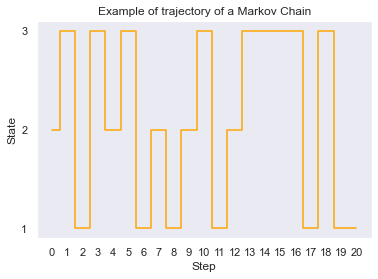

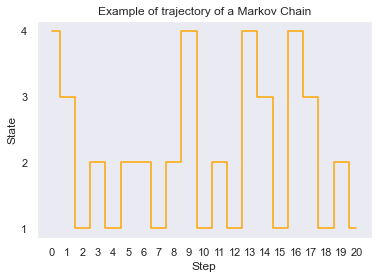

In [7]:
rng = np.random.default_rng(56588817959030)

list_rho=[
    [0.25,0.4,0.35],
    [0.4,0.1,0.3,0.2]
]

list_matrices = [
    np.array([[1/6,2/3,1/6],[1/2,0,1/2],[0.3,0.3,0.4]]),
    np.array([[0.1,0.8,0.05,0.05],[0.6,0.2,0,0.2],[1,0,0,0],[0.5,0.25,0.25,0]])
]

nmax=20

for rho, A in zip(list_rho, list_matrices):
    X=markov(rho, A, nmax, rng)
    plt.step(np.arange(0, nmax+1), X, where='mid', color='orange')
    plt.xlabel('Step')
    plt.ylabel('State')
    plt.title('Example of trajectory of a Markov Chain')
    plt.xticks(np.arange(0, nmax + 1))
    plt.yticks(np.arange(1, len(rho) + 1))
    plt.show()

3. Explore the potential of the [`multiprocessing` package](https://docs.python.org/3/library/multiprocessing.html) to simulate several Markov chains in parallel.

> Hint: the `mutiprocessing.Pool.starmap` or `mutiprocessing.Pool.starmap_async` methods could be useful.

**Answer:**

For the multiprocess to work with Jupyter Notebook, we had to put the function in a separate file. See for example this [StackOverflow](https://stackoverflow.com/questions/47313732/jupyter-notebook-never-finishes-processing-using-multiprocessing-python-3/47374811#47374811).

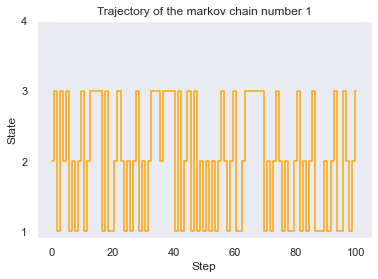

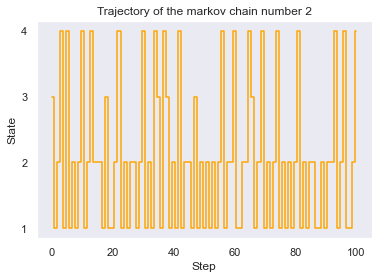

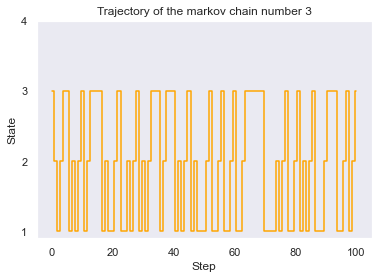

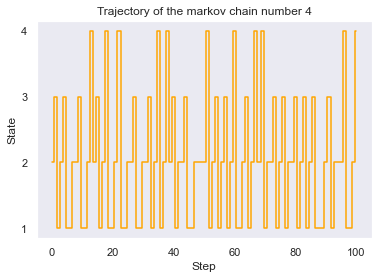

In [8]:
import markov

num_chains = 4
nmax = 100
rng = np.random.default_rng(56588817959030)

rho = [
    [0.25,0.4,0.35],
    [0.4,0.1,0.3,0.2],
    [0,0,1],
    [0.5,0.5,0,0]
]
matrices_A = [
    np.array([[1/6,2/3,1/6],[1/2,0,1/2],[0.3,0.3,0.4]]),
    np.array([[0.1,0.8,0.05,0.05],[0.6,0.2,0,0.2],[1,0,0,0],[0.5,0.25,0.25,0]]),
    np.array([[1/3,2/3,0],[1/3,0,2/3],[0.5,0.1,0.4]]),
    np.array([[0.2,0.8,0,0],[0,0.3,0.5,0.2],[1,0,0,0],[0.5,0.45,0.05,0]])
]

def simulate_markov_chains_parallel(num_chains, rho, transition_matrices, nmax, rng):
    args = [(rho[i], transition_matrices[i], nmax, rng) for i in range(num_chains)]

    # To use all available CPUs, we use cpu_count()
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.starmap(markov.markov, args)

    return results

if __name__ == '__main__':
    results = simulate_markov_chains_parallel(num_chains, rho, matrices_A, nmax, rng)

    for i, X in enumerate(results):
        plt.step(np.arange(0, nmax+1), X, where='mid', color='orange')
        plt.xlabel('Step')
        plt.ylabel('State')
        plt.title(f'Trajectory of the markov chain number {i+1}')
        plt.yticks(np.arange(1, 5))
        plt.show()


4. [Bonus] Generate Markov chains in parallel with the [`dask`](https://docs.dask.org/en/latest/futures.html) library, which offers more general parallelization functionalities (with, for instance, the use of [`Futures`](https://docs.dask.org/en/stable/futures.html), see tutorial [here](https://tutorial.dask.org/05_futures.html)). A useful example is provided [here](https://stackoverflow.com/questions/41471248/how-to-efficiently-submit-tasks-with-large-arguments-in-dask-distributed). Note that `dask` is much more versatile and powerful than `multiprocessing`, and can be useful to scale algorithms over multiple cores and/or computing nodes.

**Answer:**

In [9]:
rho = [0.25,0.4,0.35]
transition_matrix = np.array([[1/6,2/3,1/6],[1/2,0,1/2],[0.3,0.3,0.4]])

def simulate_markov_chains_dask(num_chains, rho, transition_matrix, nmax, rng):
    client = dask.Client()
    # Arguments that do not change over the different tasks are sent once
    future_args = client.scatter([rho, transition_matrix, nmax, rng])
    futures = [client.submit(markov.markov, *future_args) for _ in range(num_chains)]

    # Wait that all tasks are finished
    dask.wait(futures)
    results = client.gather(futures)
    client.close()

    return results

In [10]:
%%timeit

simulate_markov_chains_dask(100, rho, transition_matrix, 10000, rng)

4.63 s ± 725 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit

simulate_markov_chains_parallel(100, [rho]*100, [transition_matrix]*100, 10000, rng)

19.2 s ± 988 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


When handling a lot of data at once, especially data that don't fit in the memory, Dask works better than multiprocessing.

## <a name="bonus">Bonus: Parallel computing with Dask</a> [(&#8593;)](#content)

1. Take a look at the [`dask.array` documentation](https://docs.dask.org/en/stable/array-best-practices.html) and the associate [tutorial](https://tutorial.dask.org/02_array.html). Apply some of the functions introduced herein and in the [documentation](https://docs.dask.org/en/stable/array-best-practices.html) to parallelize the computation of the total variation investigated during session 2. Note that you can combine `dask` and `numba` to obtain an overall more efficient implementation. Note that timing can be worse than Numpy (`dask.array` is more specifically interesting when the data do no fit in memory).

2. Take a look at the [`dask.delayed` tutorial](https://tutorial.dask.org/03_dask.delayed.html), and go through some of the examples provided. [Best practices with the `dask.delayed` interface](https://docs.dask.org/en/stable/delayed-best-practices.html) are summarized in the documentation.

> **Remark**: an alternative to Dask: the [Ray](https://docs.ray.io/en/latest/) library.

**Answer:**

In [31]:
def gradient2D_dask(X):
    """Compute the 2D-gradient of a matrix using Dask arrays.

    Args:
        X (dask.array): an input matrix in Dask array format.

    Returns:
        XD_h (dask.array): horizontal part of the 2D-gradient.
        XD_v (dask.array): vertical part of the 2D-gradient.
    """
    if X.ndim != 2: raise ValueError("Input array must be 2-dimensional.")

    # Pad the array with the last column and last row to handle the boundary
    X_padded_h = da.pad(X, ((0, 0), (0, 1)), mode='edge')
    X_padded_v = da.pad(X, ((0, 1), (0, 0)), mode='edge')

    # Compute horizontal gradient
    XD_h = da.diff(X_padded_h, axis=1)

    # Compute vertical gradient
    XD_v = da.diff(X_padded_v, axis=0)

    return XD_h, XD_v

def tv_dask(X):
    """Compute discrete isotropic total variation (TV) of a matrix using Dask.

    Args:
        X (dask.array): an input matrix.

    Returns:
        float: the TV of X.
    """
    XDh, XDv = gradient2D_dask(X)
    TV = da.sqrt(XDh**2 + XDv**2).sum()

    return TV.compute()

In [32]:
def gradient2D(X):
    """Compute the 2D-gradient of a matrix

    Args:
        X (np.ndarray): a square or a non-square matrix

    Raises:
        ValueError: If the matrix has more than 2 dimensions

    Returns:
        XD_h (np.ndarray): horizontal part of the 2D-gradient
        XD_v (np.ndarray): vertical part of the 2D-gradient
    """
    if X.ndim != 2: raise ValueError("Input array must be 2-dimensional.")

    XD_h = np.diff(X, axis=1, append=X[:, -1:]) # append last column for boundary
    XD_v = np.diff(X, axis=0, append=X[-1:, :]) # append last line for boundary

    return XD_h, XD_v

def tv(X):
    """Compute discrete isotropic total variation (TV) of a matrix X

    Args:
        X (np.ndarray): an input matrix

    Returns:
        float: the TV of X
    """
    XDh, XDv=gradient2D(X)

    return np.sum(np.sqrt(XDh**2+XDv**2))

In [43]:
X = np.random.rand(10000, 10000)

#Test
#X=np.array([[4,1,3],[5,7,-1]])

In [44]:
%%timeit

# Split into smaller chunks for parallelization
X_dask = da.from_array(X, chunks=(500, 500))
tv_value = tv_dask(X_dask)

print(f"Total Variation: {tv_value}")

Total Variation: 51776869.697715275
Total Variation: 51776869.697715275
Total Variation: 51776869.697715275
Total Variation: 51776869.697715275
Total Variation: 51776869.697715275
Total Variation: 51776869.697715275
Total Variation: 51776869.697715275
Total Variation: 51776869.697715275
5.94 s ± 356 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%%timeit

print(f"Total Variation: {tv(X)}")

Total Variation: 51776869.69771541
Total Variation: 51776869.69771541
Total Variation: 51776869.69771541
Total Variation: 51776869.69771541
Total Variation: 51776869.69771541
Total Variation: 51776869.69771541
Total Variation: 51776869.69771541
Total Variation: 51776869.69771541
8.08 s ± 2.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


As expected, the total variation algorithm using Dask is faster (with square chunks of size 500), on a matrix of size 10000*10000. Moreover, the classic algorithm execution time has a standard variation of almost 3s, whereas the Dask one only is 356ms. However, it seems that we lose some precision for the dask algorithm.